<a href="https://colab.research.google.com/github/abelowska/eegML/blob/main/Classes_04_nonlinear_regression_pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nonlinear regressors and Pipelines


Imports

In [73]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid", palette="deep")

import io
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

In [44]:
# constans
test_size=0.2 
random_state=42

## Load the Life Expectancy Dataset

In [9]:
# To upload from your local drive, start with the following code. 
# It will prompt you to select a file. Click on “Choose Files” 
# then select and upload the .csv file you downloaded. 

from google.colab import files
uploaded = files.upload()

Saving Life_Expectancy_Data.csv to Life_Expectancy_Data (1).csv


In [11]:
# make sure the filename matches the name of the uploaded file 
life_expectancy_data = pd.read_csv(io.BytesIO(uploaded['Life_Expectancy_Data.csv']))
life_expectancy_df = life_expectancy_data.copy()

In [12]:
life_expectancy_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [13]:
# drop NaN values
life_expectancy_df = life_expectancy_df.dropna()            

## Prepare data

In [14]:
# select BMI and GDP columns
X = life_expectancy_df[[" BMI ", "GDP"]]
X.head()

,BMI,GDP
0,19.1,584.259210
1,18.6,612.696514
2,18.1,631.744976
3,17.6,669.959000
4,17.2,63.537231


In [15]:
y = life_expectancy_df[["Schooling"]]
y.head()

,Schooling
0,10.1
1,10.0
2,9.9
3,9.8
4,9.5


### Train-test split

In [43]:
test_size

(0.2,)

In [46]:
# to ensure repeatability of splits, we set the random state
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=test_size, 
    random_state=random_state
)

In [47]:
print(f"Shape of the X train dataset: {X_train.shape}")
print(f"Shape of the X test dataset: {X_test.shape}")
print(f"Shape of the y train dataset: {y_train.shape}")
print(f"Shape of the y test dataset: {y_test.shape}")

Shape of the X train dataset: (1319, 2)
Shape of the X test dataset: (330, 2)
Shape of the y train dataset: (1319, 1)
Shape of the y test dataset: (330, 1)


## Model fitting with pre-processing

A range of preprocessing algorithms in scikit-learn allow us to transform the input data before training a model. In our case, we will standardize the data and after that train a model on our scaled dataset. 

### Scaler

In [18]:
X_train.describe()

,BMI,GDP
count,1319.000000,1319.000000
mean,37.941016,5668.715438
std,19.846596,11971.059185
min,2.000000,1.681350
25%,19.350000,458.876265
50%,43.000000,1536.156850
75%,55.700000,4682.028192
max,77.100000,119172.741800


We see that the dataset’s features span across different ranges. Some algorithms make some assumptions regarding the feature distributions and usually normalizing features will be helpful to address these assumptions.

For normalization we use a `scikit-learn` transformer called [`StandardScaler()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html?highlight=standard+scaler#sklearn.preprocessing.StandardScaler). This transformer shifts and scales each feature individually so that they all have a 0-mean and a unit standard deviation.

1. First, we have to fit `StandardScaler()` to learn the scaling from the data.

In [19]:
# create StandarsScaler object
scaler = StandardScaler()

# fit it to the train data
scaler.fit(X_train)

StandardScaler()

The `fit()` method for transformers is similar to the `fit()` method for predictors. The main difference is that the StandardScaler employs *unsupervised learnig*, therefore we don't have to provide target data.

We can inspect the computed means and standard deviations:

In [20]:
scaler.mean_

array([  37.94101592, 5668.71543752])

In [21]:
scaler.scale_

array([   19.83907149, 11966.52039479])

2. Once we fitted Scaler to data, we can perform *data transformation* by calling the method `transform()`.

In [22]:
X_train_scaled = scaler.transform(X_train)
X_train_scaled[:5]

array([[-0.59685333, -0.34209918],
       [ 0.86490863, -0.2581805 ],
       [-1.65033005, -0.1719381 ],
       [-0.47083937, -0.44649879],
       [-0.93457075, -0.3155111 ]])

Note that Scaler pulled data from the dataframe into an array  when transforming data: 

In [23]:
type(X_train_scaled)

numpy.ndarray

Let's look into the data:

In [24]:
X_train_scaled_df = pd.DataFrame(
    X_train_scaled,
    columns=X_train.columns
)

X_train_scaled_df.describe()

,BMI,GDP
count,1.319000e+03,1.319000e+03
mean,1.696899e-16,2.962839e-17
std,1.000379e+00,1.000379e+00
min,-1.811628e+00,-4.735741e-01
25%,-9.370910e-01,-4.353679e-01
50%,2.550011e-01,-3.453434e-01
75%,8.951520e-01,-8.245398e-02
max,1.973831e+00,9.485132e+00


All `scikit-learn` transformers implement methods:
-  `fit()`;
- `transform()`;
- `fit_transform()` which is a shorthand method to call successively fit and then transform. 

We can simplify our code:

In [25]:
X_train_scaled = scaler.fit_transform(X_train)

X_train_scaled_df = pd.DataFrame(
    X_train_scaled,
    columns=X_train.columns
)

X_train_scaled_df.describe()

,BMI,GDP
count,1.319000e+03,1.319000e+03
mean,1.696899e-16,2.962839e-17
std,1.000379e+00,1.000379e+00
min,-1.811628e+00,-4.735741e-01
25%,-9.370910e-01,-4.353679e-01
50%,2.550011e-01,-3.453434e-01
75%,8.951520e-01,-8.245398e-02
max,1.973831e+00,9.485132e+00


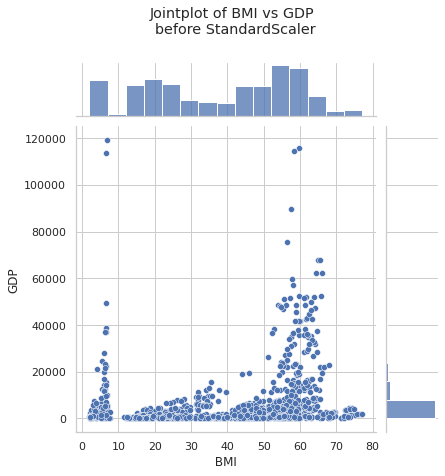

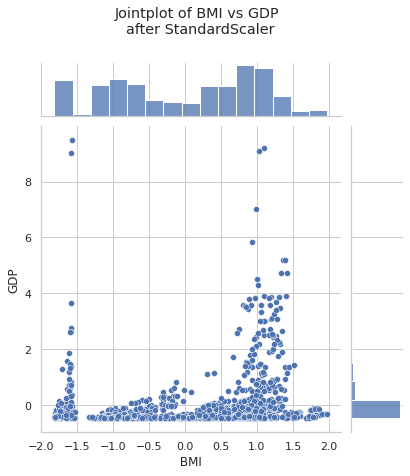

In [26]:
sns.jointplot(data=X_train, x=" BMI ",
              y="GDP", marginal_kws=dict(bins=15))
plt.suptitle("Jointplot of BMI vs GDP \nbefore StandardScaler", y=1.1)

sns.jointplot(data=X_train_scaled_df, x=" BMI ",
              y="GDP", marginal_kws=dict(bins=15))
_ = plt.suptitle("Jointplot of BMI vs GDP \nafter StandardScaler", y=1.1)

Here are some reasons for scaling features:

- Models that rely on the distance between a pair of samples, for instance k-nearest neighbors, should be trained on normalized features to make each feature contribute approximately equally to the distance computations.

- Many models such as logistic regression use a numerical solver (based on gradient descent) to find their optimal parameters. Such solvers converge faster when the features are scaled.

### Model with Pipeline framework

#### Create Pipeline

We can easily combine sequential operations with a scikit-learn [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), which chains together operations and is used as any other classifier or regressor.

According to the documentation:

> Intermediate steps of the pipeline must be *transforms*, that is, they must implement `fit()` and `transform()` methods. The `fit()` method can be no-operation (empty implementation) when given intermediate step only transform values (e.g. categorical values to numerical ones). The final estimator only needs to implement `fit()`. 



In [48]:
scaler = StandardScaler()
lm = linear_model.LinearRegression()

Pipeline input is a *steps* list -  a **list** of (name, transformer) **tuples** (implementing fit/transform).

In [49]:
# define steps
steps = [
    ('scaler', scaler), 
    ('lm', lm)
]

# create pipeline from steps list
pipe = Pipeline(steps)

Visualize the pipeline

In [50]:
set_config(display="diagram")
pipe  # click on the diagram below to see the details of each step

Pipeline(steps=[('scaler', StandardScaler()), ('lm', LinearRegression())])

#### Fit the model (Pipeline)

In [51]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('lm', LinearRegression())])

### Test model

Predict data set using `predict()` method as before:

In [52]:
y_pred = pipe.predict(X_test)

Calculate $R^2$, $MAE$ and $MSE$

In [53]:
# The coefficient of determination: 1 is perfect prediction
print(f"Coefficient of determination: {r2_score(y_test, y_pred )}")

Coefficient of determination: 0.3908564272619536


In [54]:
# The mean absolute error
print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred )}")

Mean absolute error: 1.6133619950986458


In [55]:
# The mean squared error
print(f"Mean squared error: {mean_squared_error(y_test, y_pred )}")

Mean squared error: 4.521106164195008


### To recap:

We have just been introduced to the `Pipeline` framework and created our model as an instance of Pipeline, to chain scaling and linear regression training :)

## Non-linear features-target relationship

So far we have only considered the linear regression model. But relationships are not always (and in real life even almost never) linear. Now we will outline some of the most popular nonlinear models.

Linear models still can be used on problems where the target variable is not linearly related to the input features but this requires extra feature engineering work to transform the data in order to avoid under-fitting.

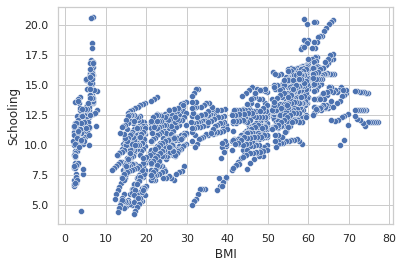

In [56]:
sns.scatterplot(
    data=life_expectancy_df,
    x = " BMI ",
    y="Schooling"
)

In [57]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    life_expectancy_df[[" BMI "]], 
    life_expectancy_df[["Schooling"]], 
    test_size=test_size, 
    random_state=random_state
)

### Linear Regression for comparison

In [58]:
scaler = StandardScaler()
lm = linear_model.LinearRegression()

In [59]:
# define steps
steps = [
    ('scaler', scaler), 
    ('lm', lm)
]

# create pipeline from steps list
pipe = Pipeline(steps)

# fit model
pipe.fit(X_train, y_train)

# predict
y_pred = pipe.predict(X_test)

# The coefficient of determination: 1 is perfect prediction
print(f"Coefficient of determination: {r2_score(y_test.to_numpy(), y_pred )}")

Coefficient of determination: 0.3005073212829473


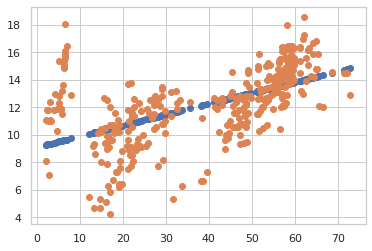

In [60]:
# plot test results

plt.scatter(X_test, y_pred) # predicted
plt.scatter(X_test, y_test) # observed

### 1. Support Vector Machines

In [61]:
# create object of SVR model
svm = SVR()

In [62]:
# define steps
steps = [
    ('scaler', scaler), 
    ('svm', svm)
]

# create pipeline from steps list
pipe = Pipeline(steps)

# fit model
# .ravel() flattens array into 1D - we ensure that y is (n_samples,)
pipe.fit(X_train, y_train.to_numpy().ravel())

# predict
y_pred = pipe.predict(X_test)

# The coefficient of determination: 1 is perfect prediction
print(f"Coefficient of determination: {r2_score(y_test, y_pred )}")

Coefficient of determination: 0.5273501655310355


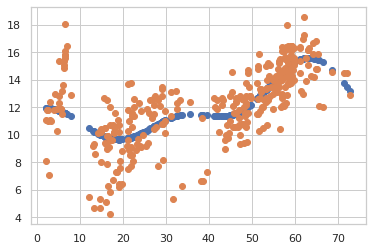

In [63]:
# plot test results

plt.scatter(X_test, y_pred) # predicted
plt.scatter(X_test, y_test) # observed

### 2. K-Nearest Neighbours

In [64]:
# create object of KNN model
knn = KNeighborsRegressor()

In [65]:
# define steps
steps = [
    ('scaler', scaler), 
    ('knn', knn)
]

# create pipeline from steps list
pipe = Pipeline(steps)

# fit model
pipe.fit(X_train, y_train.to_numpy().ravel())

# predict
y_pred = pipe.predict(X_test)

# The coefficient of determination: 1 is perfect prediction
print(f"Coefficient of determination: {r2_score(y_test, y_pred )}")

Coefficient of determination: 0.5264795569553249


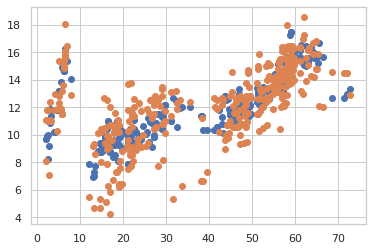

In [66]:
# plot test results

plt.scatter(X_test, y_pred) # predicted
plt.scatter(X_test, y_test) # observed

### 3. Decision Trees

In [67]:
tree = DecisionTreeRegressor()

In [68]:
# define steps
steps = [
    ('scaler', scaler), 
    ('tree', tree)
]

# create pipeline from steps list
pipe = Pipeline(steps)

# fit model
pipe.fit(X_train, y_train.to_numpy().ravel())

# predict
y_pred = pipe.predict(X_test)

# The coefficient of determination: 1 is perfect prediction
print(f"Coefficient of determination: {r2_score(y_test, y_pred )}")

Coefficient of determination: 0.4305196037608069


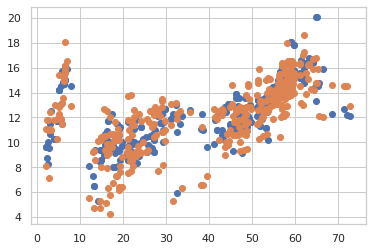

In [69]:
# plot test results

plt.scatter(X_test, y_pred) # predicted
plt.scatter(X_test, y_test) # observed

## Cross-validation

Let's imagine that we have to choose the best model to and **then** perform a final testing.

We can simplify our code:

In [74]:
# create models for comparison

lm = linear_model.LinearRegression()
svm = SVR()
knn = KNeighborsRegressor()
tree = DecisionTreeRegressor()

estimators = [lm, svm, knn, tree]

In [75]:
results_df = pd.DataFrame()

for estimator in estimators:
  # define steps
  steps = [
      ('scaler', StandardScaler()), 
      ('estimator', estimator)
  ]

  # create pipeline from steps list
  pipe = Pipeline(steps)

  # fit model
  pipe.fit(X_train, y_train.to_numpy().ravel())

  # predict on train set to compare models
  y_train_pred = pipe.predict(X_train)
  train_r2 = r2_score(y_train, y_train_pred)

  # define model name
  model_name = type(estimator).__name__

  # save results in dataframe

  this_result = pd.DataFrame({
      "model_name": [model_name],
      "train score": [train_r2],
  })

  results_df = results_df.append(this_result)

In [76]:
  results_df

,model_name,train score
0,LinearRegression,0.309451
0,SVR,0.526354
0,KNeighborsRegressor,0.694074
0,DecisionTreeRegressor,0.762542


Based on the train scores we'll probably choose Decision Tree or KNN.

Let's check the validation (test) scores of tested models.

In [77]:
results_df = pd.DataFrame()

for estimator in estimators:
  # define steps
  steps = [
      ('scaler', StandardScaler()), 
      ('estimator', estimator)
  ]

  # create pipeline from steps list
  pipe = Pipeline(steps)

  # fit model
  pipe.fit(X_train, y_train.to_numpy().ravel())

  # predict on test set
  y_pred = pipe.predict(X_test)
  test_r2 = r2_score(y_test, y_pred )

  # predict on train set to check overfitting
  y_train_pred = pipe.predict(X_train)
  train_r2 = r2_score(y_train, y_train_pred)

  # define model name
  model_name = type(estimator).__name__

  # save results in dataframe

  this_result = pd.DataFrame({
      "model_name": [model_name],
      "train score": [train_r2],
      "test_score": [test_r2],
  })

  results_df = results_df.append(this_result)

In [78]:
results_df

,model_name,train score,test_score
0,LinearRegression,0.309451,0.300507
0,SVR,0.526354,0.527350
0,KNeighborsRegressor,0.694074,0.526480
0,DecisionTreeRegressor,0.762542,0.430520


It is clear that some models are overfitted. 


Obviously, given the phenomenon of overfitting, the model with the best score on the training set is not the model with the best score on the test set. 

Cross-validation provides better estimates of the real prodictive performance of tested models.

### Estimate cross-validated train score

In [79]:
results_df = pd.DataFrame()

for estimator in estimators:
  # define steps
  steps = [
      ('scaler', StandardScaler()), 
      ('estimator', estimator)
  ]

  # create pipeline from steps list
  pipe = Pipeline(steps)

  # compute cross validated scores on train data
  cv_scores = cross_val_score(pipe, X_train, y_train.to_numpy().ravel(), cv=3)
  mean_cv_score = np.mean(cv_scores)

  # fit model
  pipe.fit(X_train, y_train.to_numpy().ravel())

  # predict on test set
  y_pred = pipe.predict(X_test)
  test_r2 = r2_score(y_test, y_pred )

  # predict on train set to check overfitting
  y_train_pred = pipe.predict(X_train)
  train_r2 = r2_score(y_train, y_train_pred)

  # define model name
  model_name = type(estimator).__name__

  # save results in dataframe

  this_result = pd.DataFrame({
      "model_name": [model_name],
      "train score": [train_r2],
      "test_score": [test_r2],
      "mean_cv_score": [mean_cv_score],
      "cv_scores": [cv_scores],
  })

  results_df = results_df.append(this_result)

In [80]:
results_df

,model_name,train score,test_score,mean_cv_score,cv_scores
0,LinearRegression,0.309451,0.300507,0.306414,"[0.32911138216120694, 0.28384816043626315, 0.3..."
0,SVR,0.526354,0.527350,0.514902,"[0.5364072651382923, 0.4836334755579902, 0.524..."
0,KNeighborsRegressor,0.694074,0.526480,0.547124,"[0.566169414715199, 0.5501159901265282, 0.5250..."
0,DecisionTreeRegressor,0.762542,0.430520,0.361158,"[0.37917098755515355, 0.4145111350881516, 0.28..."


Now we see that cross-validation is much more reliable than a simple test score. This is very important especially when comparing different models before final testing. **Relying only on the train score can lead to an overestimation of the model's performance and predictive power.**